* Design a variation of a VAE that

      * takes in two inputs:

            * an MNIST image, and

            * its label (one hot encoded vector sent through an embedding layer)

* Training as you would train a VAE

* Now randomly send a CIFAR10 image, but with a wrong label. Do this 25 times,

* And share 25 images (1 stacked image)!

### Install different required libraries

In [1]:
! pip install pytorch-lightning
!git clone https://github.com/PyTorchLightning/pytorch-lightning-bolts.git
%cd pytorch-lightning-bolts
!git checkout v0.2.5rc1
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 9.8 MB/s eta 0:00:00
Cloning into 'pytorch-lightning-bolts'...
remote: Enumerating objects: 9800, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 9800 (delta 11), reused 1 (delta 1), pack-reused 9782
Receiving objects: 100% (9800/9800), 5.09 MiB | 1.70 MiB/s, done.
Resolving deltas: 100% (7015/7015), done.
/content/pytorch-lightning-bolts
error: pathspec 'v0.2.5rc1' di

### Define VAE

In [2]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32, num_labels=10, label_embedding_dim=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim + label_embedding_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim + label_embedding_dim, latent_dim)

        # label embedding
        self.label_embedding = nn.Embedding(num_labels, label_embedding_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, y = batch

        # label embedding
        y_embedded = self.label_embedding(y)

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        x_encoded_with_labels = torch.cat([x_encoded, y_embedded], dim=1)
        mu, log_var = self.fc_mu(x_encoded_with_labels), self.fc_var(x_encoded_with_labels)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo


/content/pytorch-lightning-bolts/pl_bolts/callbacks/data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
/content/pytorch-lightning-bolts/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/content/pytorch-lightning-bolts/pl_bolts/models/self_supervised/amdim/amdim_modul

### Train VAE on CIFAR10 dataset

In [3]:
from pl_bolts.datamodules import CIFAR10DataModule
datamodule = CIFAR10DataModule('.')
pl.seed_everything(1234)
vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=30)#, progress_bar_refresh_rate=10)
trainer.fit(vae, datamodule)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_lite.utilities.seed:Global seed set to 1234
<ipython-input-2-743a7af1f6f4>:15: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/content/pytorch-lightning-bolts/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compati

100%|██████████| 170498071/170498071 [00:05<00:00, 28508430.10it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params
--------------------------------------------------
0 | encoder         | ResNetEncoder | 11.2 M
1 | decoder         | ResNetDecoder | 8.6 M 
2 | fc_mu           | Linear        | 139 K 
3 | fc_var          | Linear        | 139 K 
4 | label_embedding | Embedding     | 320   
--------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.295    Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performanc

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


#### Now randomly send a CIFAR10 image, but with a wrong label. Do this 25 times,

#### And share 25 images (1 stacked image)!

Files already downloaded and verified


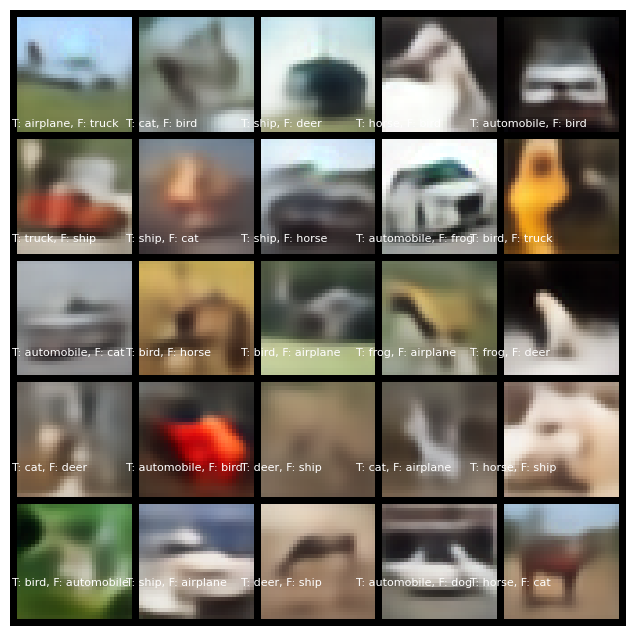

In [25]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Set the device to be used for tensor computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the VAE to the same device
vae.to(device)

# Set the VAE to evaluation mode
vae.eval()

# Initialize an empty tensor to store the reconstructed images and corresponding labels
reconstructed_images = torch.empty((25, 3, 32, 32))
labels = []

for i in range(25):
    # Randomly select an image and its true label from the test dataset
    index = torch.randint(len(test_dataset), size=(1,)).item()
    image, true_label = test_dataset[index]
    
    # Create a tensor with a randomly chosen incorrect label
    incorrect_label = torch.randint(low=0, high=10, size=(1,)).item()
    while incorrect_label == true_label:
        incorrect_label = torch.randint(low=0, high=10, size=(1,)).item()
    incorrect_label_tensor = torch.tensor([incorrect_label])
    
    # Move the image and label tensors to the same device as the VAE
    image = image.to(device)
    incorrect_label_tensor = incorrect_label_tensor.to(device)
    
    # Encode the image and the incorrect label into the latent space
    encoded = vae.encoder(image.unsqueeze(0))
    incorrect_label_embedding = vae.label_embedding(incorrect_label_tensor)
    encoded_with_labels = torch.cat([encoded, incorrect_label_embedding], dim=1)
    mu, log_var = vae.fc_mu(encoded_with_labels), vae.fc_var(encoded_with_labels)
    
    # Sample from the distribution
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    
    # Decode the latent vector into an image
    reconstructed_image = vae.decoder(z)
    
    # Store the reconstructed image and corresponding label in the tensors
    reconstructed_images[i] = reconstructed_image.squeeze(0)
    labels.append(f'True: {true_label}, Incorrect: {incorrect_label}')

# Concatenate the 25 reconstructed images into a single image for visualization
reconstructed_grid = torchvision.utils.make_grid(reconstructed_images, nrow=5)
reconstructed_grid = reconstructed_grid.permute(1, 2, 0).cpu().detach().numpy()

# Visualize the reconstructed image grid with labels
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(reconstructed_grid)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

for i, label in enumerate(labels):
    row, col = i // 5, i % 5
    x = col * 32
    y = row * 32 + 30
    true_label = label.split(',')[0].split(': ')[1]
    incorrect_label = label.split(',')[1].split(': ')[1]
    label_text = f"T: {test_dataset.classes[int(true_label)]}, F: {test_dataset.classes[int(incorrect_label)]}"
    ax.text(x, y, label_text, color='white', fontsize=8, ha='left', va='top')
